# Task - 1 

**Objective:** The objective is to define a classification algorithm that will classify an image into $3$ different classes.

**Dataset Description:** The Dataset consists of three classes, strong lensing images

* `no substructure`
* `subhalo substructure`
* `vortex substructure`

The images have been normalized using min-max normalization. 

**Evaluation Metrics:** The ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve) are used to evaluate the classification models.


> This notebook is used for Exploratory Data Analysis of the data and Baseline modelling. For experiment tracking I have used `wandb`


 Notebook color scheme 

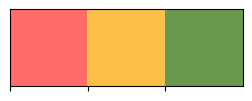

In [34]:
from typing import Any, List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import lightning.pytorch as pl
import torchmetrics
import albumentations
import torch.nn as nn
import torch.utils.data as td
import torch.nn.functional as F
import wandb
import os
import warnings
import sys
import json

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from IPython.display import display_markdown, display_latex
from matplotlib.colors import ListedColormap
from rich.progress import track
from rich.console import Console
from rich.table import Table
from rich import print as rprint

MY_COLORS = ["#ff6b6b", "#fcbf49", "#6a994e"]
MY_COLORMAP = ListedColormap(MY_COLORS)

WANDB_CONFIG = {"experiment":"GSoc2023", "_wandb_kernel":"aot"}

rprint("[bold #ff6b6b] Notebook color scheme [/bold #ff6b6b]")
sns.palplot(sns.color_palette(MY_COLORS))
plt.show()

In [2]:
api_key = os.environ["WANDB_API_KEY"]
!wandb login $api_key

wandb: Appending key for api.wandb.ai to your netrc file: /home/darthvader/.netrc


# Create MetaData

The data is split into $3$ directories, where each directory represents a class. The first step in the pipeline is to create a **metaData** of these image data. 

To create the **metaData** the best process is to iterate through each of these directories and save it's image paths and the directory name into a list. Once that's done
we can then create a dataframe to obtain the **metaData** for the images.

The structure of the dataset will be as follows:

| paths                                    | label  |
|------------------------------------------|--------|
| ../data/datasets/dataset/no/1.jpg        | no     |
| ../data/datasets/dataset/vort/200.jpg    | vort   |
| ../data/datasets/dataset/sphere/2100.jpg | sphere |

where `paths` represents the image paths of the data and `label` represents the target class to which the image belongs.

In [3]:
def metaCreate(root_dir:str, sub_dir:str) -> "pd.DataFrame":
    """
    This function is used to create the metaData for the files.

    :param root_dir: the root directory of the datasets.
    :param sub_dir: the sub-directory, i.e. train/val in the datasets.

    :returns: a dataframe consisting of the data paths and their corresponding labels
    """
    data = {"path":list(), "label":list()}

    for folder in os.listdir(os.path.join(root_dir, sub_dir)):
        if not folder.startswith("."):
            for files in os.listdir(os.path.join(root_dir, sub_dir, folder)):
                data["path"].append(os.path.join(root_dir, sub_dir, folder, files))
                data["label"].append(folder)

    data = pd.DataFrame(data)
    data = data.sample(frac=1, random_state=1234)
    return data

In [4]:
df_train = metaCreate("../data/dataset/dataset/", "train/")
df_val = metaCreate("../data/dataset/dataset/", "val/")

rprint(f"[italic #ff6b6b] Shape of the training dataframe [/italic #ff6b6b]: {df_train.shape}")
rprint(f"[italic #fcbf49] Shape of the validation dataframe [/italic #fcbf49]: {df_val.shape}")

 Shape of the training dataframe : (30000, 2)

 Shape of the validation dataframe : (7500, 2)

# Exploratory Data Analysis

In [5]:
def print_table(data:"pd.DataFrame", head:Optional[int]=5, title:Optional[str]="Title") -> None:
    """
    This function is used for pretty printing pandas dataframe

    :param data: a dataframe which needs to be pretty printed.
    :param head: the number of rows to print of the dataframe.
    :param title: a title to give the table.

    """

    data = data.head(head)

    table = Table(title=title)
    table.add_column("Image Paths", justify="right", style=MY_COLORS[2], no_wrap=True)
    table.add_column("Label", justify="center", style=MY_COLORS[1])

    for row in data.iterrows():
        table.add_row(row[1][0], row[1][1])

    console = Console()
    console.rule(f"[bold {MY_COLORS[0]}] {title}")
    console.print(table)

print_table(df_train, head=5, title="Training Data")
print_table(df_val, head=5, title="Validation Data")



─────────────────────────────────────────────────  Training Data ──────────────────────────────────────────────────

                     Training Data                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃                                 Image Paths ┃ Label ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│   ../data/dataset/dataset/train/no/3566.npy │  no   │
│    ../data/dataset/dataset/train/no/951.npy │  no   │
│    ../data/dataset/dataset/train/no/530.npy │  no   │
│ ../data/dataset/dataset/train/vort/1819.npy │ vort  │
│ ../data/dataset/dataset/train/vort/6170.npy │ vort  │
└─────────────────────────────────────────────┴───────┘

────────────────────────────────────────────────  Validation Data ─────────────────────────────────────────────────

                    Validation Data                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃                                 Image Paths ┃ Label  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│    ../data/dataset/dataset/val/vort/687.npy │  vort  │
│       ../data/dataset/dataset/val/no/90.npy │   no   │
│     ../data/dataset/dataset/val/no/2370.npy │   no   │
│ ../data/dataset/dataset/val/sphere/2234.npy │ sphere │
│      ../data/dataset/dataset/val/no/374.npy │   no   │
└─────────────────────────────────────────────┴────────┘

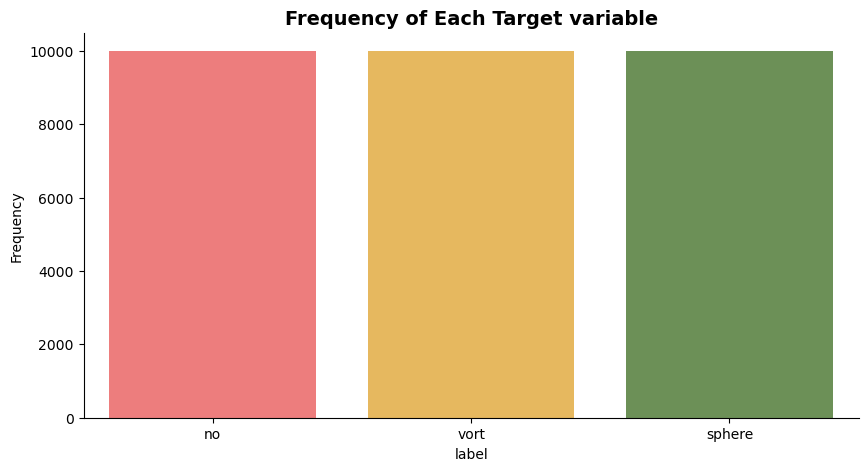

In [6]:
plt.figure(figsize=(10, 5))
plt.title("Frequency of Each Target variable", fontdict={'fontsize':14, 'weight':'bold'})
sns.countplot(data=df_train, x="label", palette=MY_COLORS, order=['no', 'vort', 'sphere'])
plt.ylabel('Frequency')
sns.despine()
plt.show()

Next step, I try to visualize the target distribution in our dataset. In the above code cell, I plot the frequency of each classes in our dataset. Upon looking at the above graph, it is clear that each of our $3$ classes is distributed equally. 

Therefore, it is clear that we are not dealing with any **rare-classes** in our dataset. 

If there were rare-classes in our dataset, additional steps would have been required in our classification algorithm. 

In [7]:
run = wandb.init(project="GSOC23-Task1", name="sample_images", config=WANDB_CONFIG)

wandb: Currently logged in as: lmorningstar. Use `wandb login --relogin` to force relogin


In [8]:
def view_sample_imgs(data:"pd.DataFrame", target:str, n_samples:Optional[int]=5) -> None:
    """
    This function is used to plot and view sample images in our dataset

    :param data: the complete dataframe consisting of all image paths and their corresponding labels.
    :param target: the target variable whose images needs to be viewed.
    :param n_samples: the amount of images to view.

    :returns: None
    """

    data = data.loc[data["label"] == target].sample(n_samples, random_state=32)
    fig, axs = plt.subplots(1, n_samples, figsize=(24, 15))
    axs = axs.flatten()

    col = {'no':MY_COLORS[0], 'vort' : MY_COLORS[1], 'sphere' : MY_COLORS[2]}
    wandb_imgs = list()

    for i in range(n_samples):
        img_arr = np.load(data.iloc[i]["path"])
        img_arr = np.transpose(img_arr, (2, 1, 0))
        
        wandb_imgs.append(wandb.Image(img_arr))
        
        img = Image.fromarray((img_arr.squeeze(axis=2) * 255).astype(np.uint8), "L")
        
        img = img.resize((512, 512), resample=Image.Resampling.BILINEAR)

        axs[i].set_title(f"{i+1} - {target}", fontsize=15, weight="bold", color=col[target])
        axs[i].imshow(img)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()
    
    wandb.log({target: wandb_imgs})
    




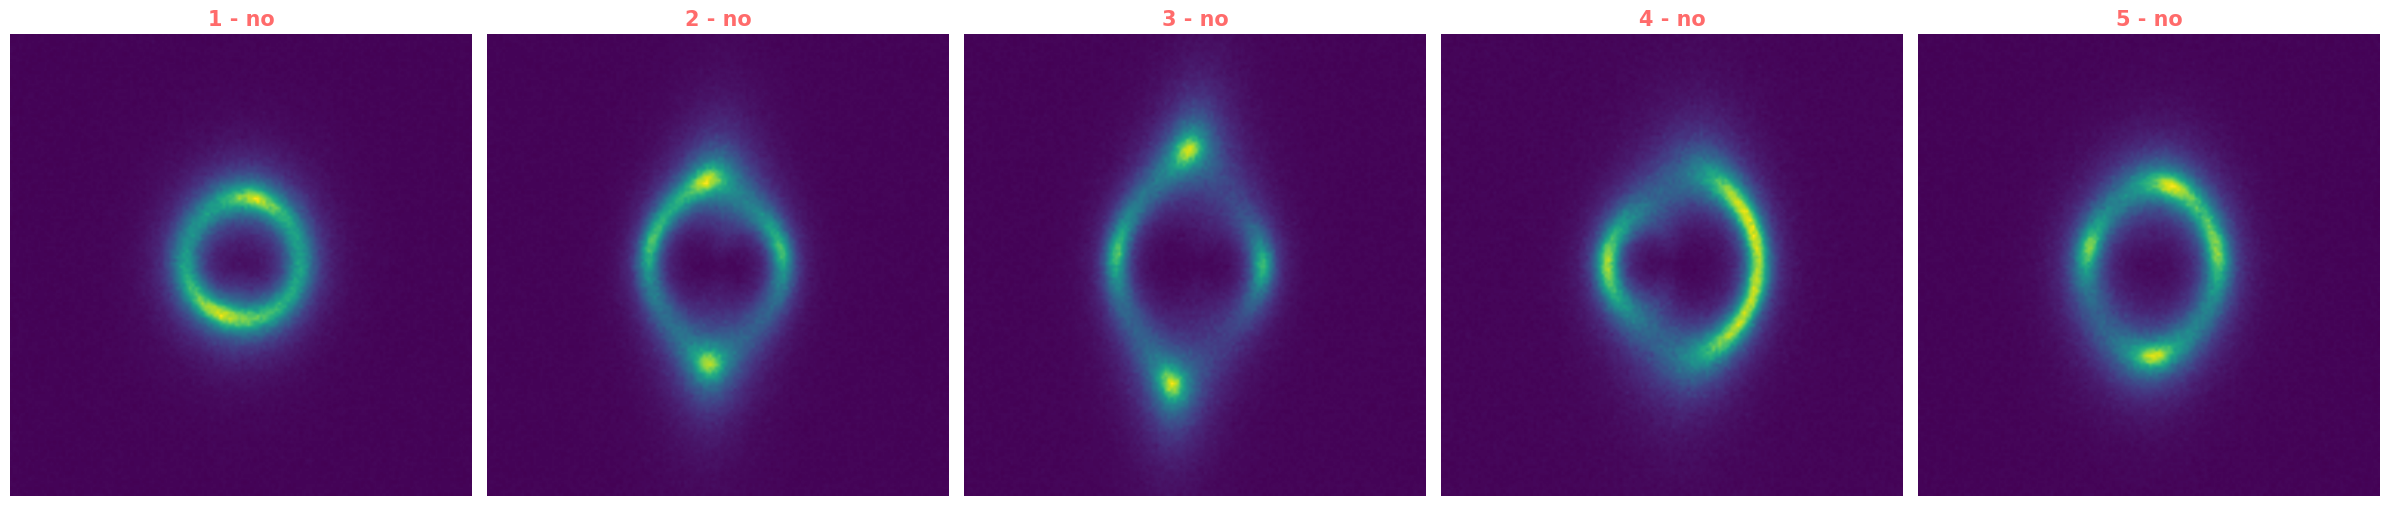

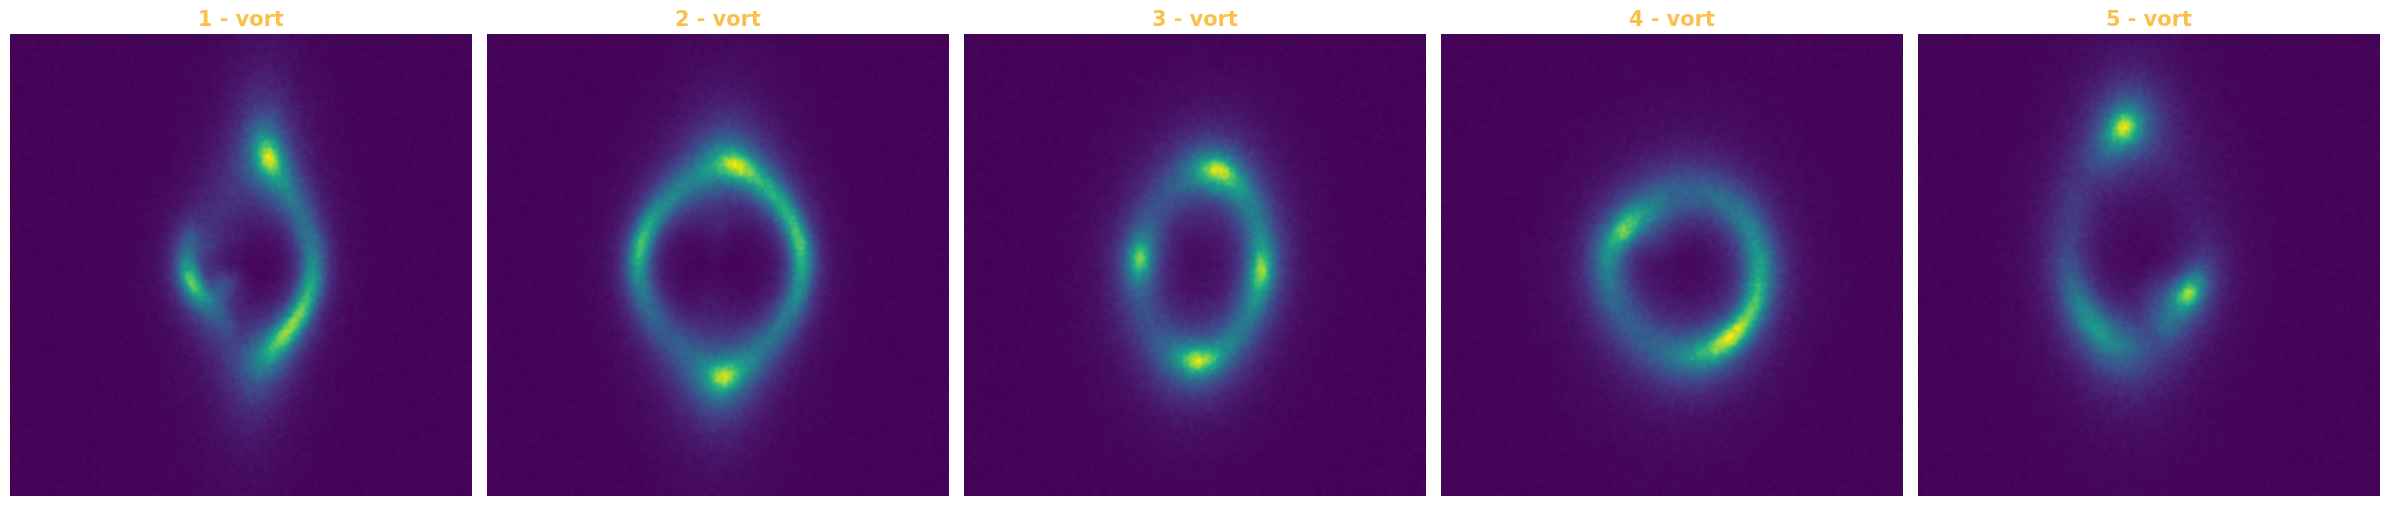

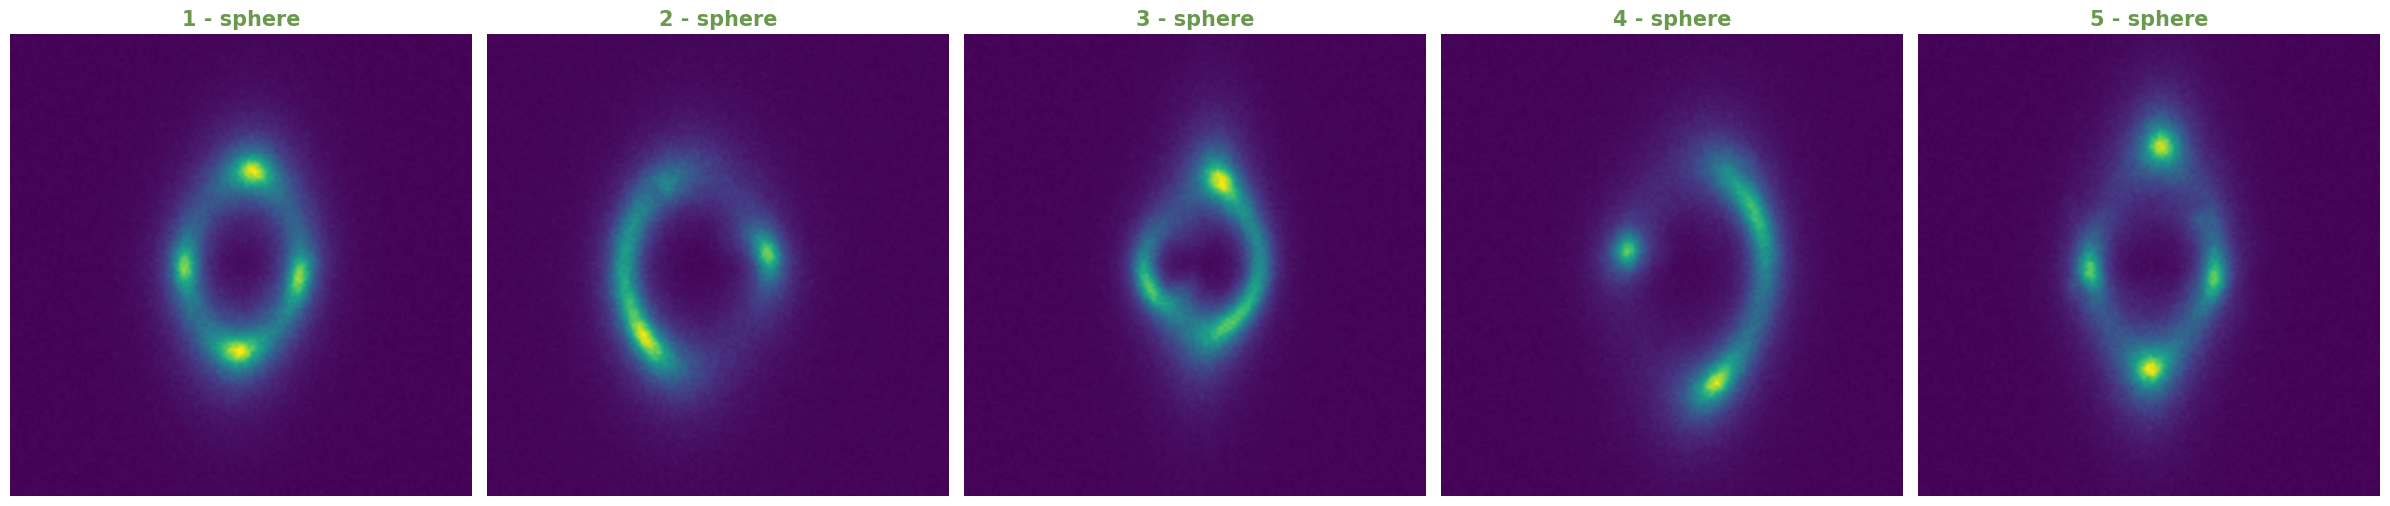

In [9]:
for target in df_train['label'].unique():
    view_sample_imgs(df_train, target)

In the above code cell(s) I have tried to visualize the image with which we are dealing. Since I am no expert in *Dark Matter Physics* all the above images for each
of the $3$ different classes in our dataset looks the same to me. However there are certain things, I did encounter while processing the images.

* First, the images stored are stored as `.npy` files.
* Next the shape of the images were saved as channel-first mode i.e., `(C, H, W)` or `(C, W, H)` .
* The images were grayscale images and since they were min-max normalized, therefore their values were capped between $[0, 1]$

In [10]:
wandb.finish()

# Baseline System

## Creating DataLoaders

Before creating the baseline, I have to build the `DataLoader`. The objective of the `DataLoader` is to load the data into batches into the model, and then the model
trains on the batched data using gradient descent. 

As I am using `PyTorch Lightning` instead of vanilla `PyTorch` I have created two different classes for my dataset and dataloaders where one inherits from `torch.utils.data.Dataset` and the other 
inherits from `lightning.pytorch.LightningDataModule`. 


1. The first one - `LensDataset` is the **dataset class**. The objective of this class is to load the images for a given class from it's corresponding directory and then resize, apply transformation and return it as python dictionary. Each dictionary contains two keys - `img` and `label`. The corresponding values of these two keys are `torch.tensor(...)` objects.

2. The second one - `LitLensDataset` is the **dataloader class**. The objective of this class is to create and load the `LensDataset` for each of our training and validation datasets, and 
then create dataloaders for each of those `LensDataset`. 

In [11]:
LABELS2IDX = {k:v for v, k in enumerate(df_train['label'].unique())}
IDX2LABELS = {v:k for k, v in LABELS2IDX.items()}


class LensDataset(td.Dataset):
    def __init__(self, data: "pd.DataFrame", resize: Optional[Tuple]=None, transformations: Optional["albumentations.Compose"]=None):
        
        self.data = data
        self.resize = resize
        self.transformations = transformations

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int) -> Dict:
        
        path = self.data.iloc[index]["path"]
        label = self.data.iloc[index]["label"]

        img = np.load(path)
        img = np.transpose(img, (2, 1, 0)) # Converting to CHW to HWC for resizing and transformations
        
        img = Image.fromarray(img.squeeze(axis=-1))
        
        if self.resize is not None:
            img = img.resize((self.resize[0], self.resize[1]), resample=Image.Resampling.BILINEAR)
        
        img = np.array(img)
        img = np.expand_dims(img, -1) # Converting from (h, w) -> (h, w, 1) where 1 indicates a greyscale channel image
        img = img.repeat(3, axis=-1) # Converting from a single channel i.e. (h, w) -> (h, w, 3)
        
        if self.transformations is not None:
            transform = self.transformations(image=img)
            img = transform["image"]

        
        img = np.transpose(img, (2, 0, 1)).astype(np.float32) # Converting back to CHW from HWC 

        return {
            "img" : torch.tensor(img, dtype=torch.float),
            "label" : torch.tensor(LABELS2IDX[label], dtype=torch.long)
        }

In [12]:
class LitLensDataset(pl.LightningDataModule):
    def __init__(self, data: "pd.DataFrame", resize: Optional[Tuple]=None, transformations: Optional["albumentations.Compose"]=None, batch_sz: Optional[int]=64):
        self.data = data
        self.resize = resize
        self.transformations = transformations
        self.batch_sz = batch_sz

        self.train = None
        self.val = None
        self.test = None

    def setup(self, stage: Optional[str]="train"):
        
        if stage not in ["train", "val", "test"]:
            raise Exception(f"Expected stage to be either of the two 'train/val/test'. Found {stage}.")
        
        if stage == "train":
            self.train = LensDataset(self.data, resize=self.resize, transformations=self.transformations)
        
        elif stage == "val":
            self.val = LensDataset(self.data, resize=self.resize, transformations=self.transformations)

        else:
            self.test = LensDataset(self.data, resize=self.resize, transformations=self.transformations)


    def train_dataloader(self) -> "td.DataLoader":
        return td.DataLoader(self.train, batch_size=self.batch_sz, shuffle=True, 
                             num_workers=4, pin_memory=True)
    
    def val_dataloader(self) -> "td.DataLoader":
        return td.DataLoader(self.val, batch_size=self.batch_sz, shuffle=False, 
                             num_workers=4, pin_memory=True)

    def test_dataloader(self) -> "td.DataLoader":
        return td.DataLoader(self.test, batch_size=self.batch_sz, shuffle=False, 
                             num_workers=4, pin_memory=True)

## Model

For the baseline model I went with VGG-19 with Batch Normalization. The baseline model-`LitClassifier` was also built `PyTorch Lightning`. Unlike vanilla PyTorch, in this case the class
consists of additional functions along with `__init__(...)` and `forward(...)` function. The additional functions which I have used in my class are as follows:

* `training_step(...)` - Defines the training step of the baseline network.
* `validation_step(...)` - Defines the validation step of the baseline network.
* `test_step(...)` - Defines the testing phase of the baseline network.
* `on_train_epoch_end(...)` - Defines additional operations that are required to be performed after a single training epoch.
* `on_validation_epoch_end(...)` - Defines the additional operations that are required to be performed after a single validation epoch.
* `on_test_epoch_end(...)` - Defines the additional operations that are required to be performed after testing the model.
* `compute_loss(...)` - Defines the calculation function of the loss function for the baseline model.
* `compute_metrics(...)` - Defines the calculation of different evaluation metrics for our model.
* `configure_optimizer(...)` - Defines the optimizer configuration and learning schedulers for our model.

In [13]:
class LitClassifier(pl.LightningModule):
    def __init__(self, n_classes: int, lr: Optional[float]=1e-4, min_lr: Optional[float]=1e-6, weight_decay: Optional[float]=1e-6,
                wandb_log: Optional["wandb.Api"] = None):

        super().__init__()
        
        self.model = torchvision.models.vgg19_bn(weights=torchvision.models.VGG19_BN_Weights.IMAGENET1K_V1)
        self.model.classifier[-1] = nn.Identity()
        self.classifier = nn.Linear(in_features=4096, out_features=n_classes)

        self.train_res = dict(acc=list(), f1=list(), aucroc=list())
        self.val_res = dict(acc=list(), f1=list(), aucroc=list())
        self.test_res = dict(acc=list(), f1=list(), aucroc=list(), loss=list())

        self.lr = lr
        self.min_lr = min_lr
        self.weight_decay = weight_decay
        
        self.wandb_log = wandb_log
        
        self.accScore = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes, average="weighted")
        self.f1Score = torchmetrics.F1Score(task="multiclass", num_classes=n_classes, average='weighted')
        self.auc_roc = torchmetrics.AUROC(task="multiclass", num_classes=n_classes)

        self.save_hyperparameters('lr', 'min_lr', 'weight_decay')

    def forward(self, x: "torch.Tensor"):
        feats = self.model(x)
        logits = self.classifier(feats)

        return logits
    
    def compute_loss(self, logits: "torch.Tensor", y: "torch.Tensor") -> "torch.Tensor":
        return F.cross_entropy(logits, y)
    

    def compute_metrics(self, logits: "torch.Tensor", y:"torch.Tensor") -> Dict:
        
        yhat = torch.argmax(logits, dim=-1)

        return {
            'accScore' : self.accScore(yhat, y),
            'f1Score' : self.f1Score(yhat, y),
            'aucrocScore' : self.auc_roc(logits, y)
        }

    
    def training_step(self, batch, batch_idx):
        x, y = batch["img"], batch["label"]
        logits = self(x)
        loss = self.compute_loss(logits, y)

        metrics = self.compute_metrics(logits, y)

        self.train_res['acc'].append(metrics['accScore'])
        self.train_res['f1'].append(metrics['f1Score'])
        self.train_res['aucroc'].append(metrics['aucrocScore'])

        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True, logger=True)
        
        if self.wandb_log is not None:
            self.wandb_log.log({"train/loss" : loss})

        return loss
    
    def validation_step(self, batch, batch_idx):

        x, y = batch["img"], batch["label"]
        
        logits = self(x)
        loss = self.compute_loss(logits, y)

        metrics = self.compute_metrics(logits, y)

        self.val_res['acc'].append(metrics['accScore'])
        self.val_res['f1'].append(metrics['f1Score'])
        self.val_res['aucroc'].append(metrics['aucrocScore'])

        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True, logger=True)
        
        if self.wandb_log is not None:
            self.wandb_log.log({"val/loss" : loss})        

        return loss        
    
    def test_step(self, batch, batch_idx):

        x, y = batch["img"], batch["label"]
        
        logits = self(x)
        loss = self.compute_loss(logits, y)

        metrics = self.compute_metrics(logits, y)

        self.test_res['acc'].append(metrics['accScore'])
        self.test_res['f1'].append(metrics['f1Score'])
        self.test_res['aucroc'].append(metrics['aucrocScore'])
        self.test_res['loss'].append(loss)

        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True, logger=True)

        return loss           
    

    def on_train_epoch_end(self):

        all_acc = torch.stack(self.train_res['acc']).mean()
        all_f1 = torch.stack(self.train_res['f1']).mean()
        all_aucroc = torch.stack(self.train_res['aucroc']).mean()

        self.log('train_acc', all_acc, logger=True)
        self.log('train_f1', all_f1, logger=True)
        self.log('train_aucroc', all_aucroc, logger=True)
        
        self.train_res['acc'].clear()
        self.train_res['f1'].clear()
        self.train_res['aucroc'].clear()
        
        if self.wandb_log is not None:
            self.wandb_log.log({'train/Accuracy': all_acc})
            self.wandb_log.log({'train/F1Score' : all_f1})
            self.wandb_log.log({'train/AUCROC' : all_aucroc})


    def on_validation_epoch_end(self):


        all_acc = torch.stack(self.val_res['acc']).mean()
        all_f1 = torch.stack(self.val_res['f1']).mean()
        all_aucroc = torch.stack(self.val_res['aucroc']).mean()

        self.log('val_acc', all_acc, logger=True)
        self.log('val_f1', all_f1, logger=True)
        self.log('val_aucroc', all_aucroc, logger=True)
        
        self.val_res['acc'].clear()
        self.val_res['f1'].clear()
        self.val_res['aucroc'].clear()
        
        if self.wandb_log is not None:
            self.wandb_log.log({'val/Accuracy': all_acc})
            self.wandb_log.log({'val/F1Score' : all_f1})
            self.wandb_log.log({'val/AUCROC' : all_aucroc})        
        
        
    def on_test_epoch_end(self):


        all_acc = torch.stack(self.test_res['acc']).mean()
        all_f1 = torch.stack(self.test_res['f1']).mean()
        all_aucroc = torch.stack(self.test_res['aucroc']).mean()
        all_loss = torch.stack(self.test_res['loss']).mean()

        self.log('test_acc', all_acc, logger=True)
        self.log('test_f1', all_f1, logger=True)
        self.log('test_aucroc', all_aucroc, logger=True)
        self.log('test_loss', all_loss, logger=True)
        
        self.test_res['acc'].clear()
        self.test_res['f1'].clear()    
        self.test_res['aucroc'].clear()
        self.test_res['loss'].clear()
        
        return {
            "accuracy" : all_acc,
            "f1Score" : all_f1,
            "aucroc" : all_aucroc, 
            "loss" : all_loss
        }


    def configure_optimizers(self) -> Dict:
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 100, eta_min=self.min_lr)

        return {
            "optimizer" : optimizer,
            "lr_scheduler" : scheduler
        }

## Create DataLoaders

Instead of using the validation set as our validation set for the model, I have created a minivalidation set from our training set and used it for validating our model
in the validation stage of our model training.

In [14]:
train_data, minival_data = train_test_split(df_train, shuffle=True, test_size=.25, random_state=42, stratify=df_train['label'])

rprint(f"[bold #ff6b6b] Shape of the training data[/bold #ff6b6b] : {train_data.shape}")
rprint(f"[bold #6a994e] Shape of the validation data[/bold #6a994e] : {minival_data.shape}")

 Shape of the training data : (22500, 2)

 Shape of the validation data : (7500, 2)

In [15]:
train_dm = LitLensDataset(train_data, (224, 224), batch_sz=32)
val_dm = LitLensDataset(minival_data, (224, 224), batch_sz=128)

train_dm.setup(stage="train")
val_dm.setup(stage="val")

train_dl = train_dm.train_dataloader()
val_dl = val_dm.val_dataloader()

## Define Model and Trainer

In [16]:
run = wandb.init(project="GSOC23-Task1", name="baseline", config=WANDB_CONFIG)
baseline_model = LitClassifier(3, wandb_log=run)

In `PyTorch Lightning` we use something called the `Trainer` to train our networks. The `Trainer` is responsible for taking care of all the stuffs that are required 
for efficient training of our model such as `Distributed Parallel Training`, `Mixed Precision Training`, `Early Stopping`, `Model Checkpointing`, etc.

In [17]:
torch.cuda.empty_cache()

if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')

early_stop = pl.callbacks.EarlyStopping(monitor="val_aucroc", mode="max", patience=3, verbose=True)
model_check = pl.callbacks.ModelCheckpoint(dirpath="./checkpoints", 
                                           filename="best_baseline_checkpoint", 
                                           monitor="val_aucroc", mode="max", save_top_k=1, save_on_train_epoch_end=False)
prog_bar = pl.callbacks.RichProgressBar()

trainer = pl.Trainer(accelerator="gpu", 
                     devices=1, 
                     precision=16, 
                     max_epochs=100, 
                     callbacks=[early_stop, model_check, prog_bar])

trainer.fit(baseline_model, train_dataloaders=train_dl, val_dataloaders=val_dl)

/home/darthvader/miniconda3/envs/mlenv/lib/python3.10/site-packages/lightning/fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/darthvader/miniconda3/envs/mlenv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/darthvader/research/gsoc_23/T

┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model      │ VGG                │  139 M │
│ 1 │ classifier │ Linear             │ 12.3 K │
│ 2 │ accScore   │ MulticlassAccuracy │      0 │
│ 3 │ f1Score    │ MulticlassF1Score  │      0 │
│ 4 │ auc_roc    │ MulticlassAUROC    │      0 │
└───┴────────────┴────────────────────┴────────┘

Trainable params: 139 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 139 M                                                                                                
Total estimated model params size (MB): 558

Output()

Metric val_aucroc improved. New best score: 0.960
Metric val_aucroc improved by 0.014 >= min_delta = 0.0. New best score: 0.974
Metric val_aucroc improved by 0.001 >= min_delta = 0.0. New best score: 0.975
Metric val_aucroc improved by 0.007 >= min_delta = 0.0. New best score: 0.982


/home/darthvader/miniconda3/envs/mlenv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: 
UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in 
true positive score
  warnings.warn(*args, **kwargs)

Monitored metric val_aucroc did not improve in the last 3 records. Best score: 0.982. Signaling Trainer to stop.


To test our model I have used the validation set that was given to me by the GSoC datasets. 

In [29]:
test_dm = LitLensDataset(df_val, resize=(224, 224), batch_sz=128)
test_dm.setup(stage="test")
test_dl = test_dm.test_dataloader()

new_trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[pl.callbacks.RichProgressBar()])
trained_model = LitClassifier.load_from_checkpoint(checkpoint_path="./checkpoints/best_baseline_checkpoint-v2.ckpt", n_classes=3)
trained_model.freeze()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [30]:
test_res = new_trainer.test(trained_model, dataloaders=test_dl)

You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9076020121574402     │
│        test_aucroc        │    0.9812153577804565     │
│          test_f1          │    0.9066431522369385     │
│         test_loss         │    0.26968449354171753    │
└───────────────────────────┴───────────────────────────┘

In [35]:
if not os.path.exists("./results/"):
    os.mkdir("./results")
    
with open('./results/baseline_results.json', 'w') as fp:
    json.dump(test_res, fp)

In [36]:
wandb.finish()

train/AUCROC,▁▇▇████
train/Accuracy,▁▆▇▇▇██
train/F1Score,▁▆▇▇▇██
train/loss,██▇▅▅▃▃▃▂▅▄▄▄▃▂▃▂▂▁▂▂▃▃▁▁▃▁▂▃▁▂▂▂▃▁▄▂▁▂▁
val/AUCROC,▁███████
val/Accuracy,▁▇██████
val/F1Score,▁▇██████
val/loss,▇▅▅▆▅█▄▄▄▅▆▄▅▃▄▆▅▂▃▃▄▇▄▄▂▄▄▃▂▁▄▃▄▃▂▃▃▅▅▅
train/AUCROC,0.99673
train/Accuracy,0.96542
train/F1Score,0.96559
